# Import Dataset

## **Import Modules**

In [0]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf

from os import listdir
from os.path import isfile, join

## **Load OPPORTUNITY Dataset**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
mypath = '/content/gdrive/My Drive/coding/Senior Project/OpportunityUCIDataset/dataset'

files = [f for f in listdir(mypath) if isfile(join(mypath, f)) and f[-3:]=='dat' and f[-9:-4]!='Drill']
files = sorted(files)
files = [join(mypath,f) for f in files]

In [0]:
def load_data(filename):
  g = 9.8
  xyz_cols = ['x','y','z']
  using_cols = [0,23,24,25,243]
  
  df = pd.read_csv(filename, sep='\s+', usecols=using_cols,names=['ts','x','y','z','label'], header=None, engine='python')

  df = df.dropna(axis='index')
  df[xyz_cols] = df[xyz_cols].apply(lambda x: x/1000 * g)
  
  return df

In [0]:
df1 = load_data(files[0])
df2 = load_data(files[1])
df3 = load_data(files[2])

In [0]:
df1['label'].value_counts()

1    22168
0    12951
4     7437
2     6465
5     1128
Name: label, dtype: int64

In [0]:
df2['label'].value_counts()

1    10268
0     6686
2     6512
4     6314
5     1365
Name: label, dtype: int64

In [0]:
df3['label'].value_counts()

1    9958
4    7544
0    6683
2    5950
5    1294
Name: label, dtype: int64

### Note
* ** 0 - NaN **
* ** 1 - Stand **
* ** 2 - Walk **
* ** 4 - Sit **
* ** 5 - Lie **

# Preprocess Data

## **Import sklearn Library**

In [0]:
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

## **Prepare Data**

In [0]:
def normalize_data(series):
  series = np.array(series)
  
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaler = scaler.fit(series)
  
  return scaler.transform(series)

In [0]:
def prepare_data(df1):
  feature_cols = ['x','y','z']
  label_cols = ['label']

  X_series = df1[feature_cols]
  y_series = df1[label_cols]

  X_train = normalize_data(X_series)
  # Convert labels to a binary vector
  y_train = label_binarize(y_series.values, classes=[0,1,2,3,4,5])

  length = len(X_train)

  X_train = X_train.reshape((length,1,TRIAXIAL))
  y_train = y_train.reshape((length,1,LABEL_COUNT))
  
  return X_train, y_train

In [0]:
# define parameters
LABEL_COUNT = 6
TRIAXIAL = 3

In [0]:
# Load data from a certain dataframe
X_train, y_train = prepare_data(df1)
X_val, y_val = prepare_data(df2)
X_test, y_test = prepare_data(df3)

In [0]:
VALIDAT_LEN = len(X_val)
print(VALIDAT_LEN)

X_train_1 = X_train[:VALIDAT_LEN]
y_train_1 = y_train[:VALIDAT_LEN]

X_test = X_test[:VALIDAT_LEN]
y_test = y_test[:VALIDAT_LEN]

31145


In [0]:
TESTING_LEN = len(X_test)
# TRAINING_LEN = len(X_train)

print(X_train_1.shape, X_val.shape, X_test.shape)
print(y_train_1.shape, y_val.shape, y_test.shape)

print()
print(VALIDAT_LEN, TESTING_LEN)
print()

print(X_test[0])
print(y_test[0])

(31145, 1, 3) (31145, 1, 3) (31145, 1, 3)
(31145, 1, 6) (31145, 1, 6) (31145, 1, 6)

31145 31145

[[0.66486703 0.56163583 0.55995298]]
[[1 0 0 0 0 0]]


In [0]:
LABELS = [0,1,2,4,5]

d1 = y_val
# print(len(d1))
print(d1[1600][0],'\n')
  
cnter = [0,0,0,0,0,0]

for x in range(len(d1)):
  for a in range(len(d1[0])):
    for lb in LABELS:
      if d1[x][0][a]==1 and a==lb:
        cnter[a] += 1
        
print(cnter)

[0 1 0 0 0 0] 

[6686, 0, 0, 0, 0, 0]


 # Classification

## Import keras library

In [0]:
import keras

from keras import metrics
from keras import callbacks
from keras import models

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import GRU, Input, concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

In [0]:
basepath = '/content/gdrive/My Drive/coding/Senior Project/'

## **Create RNN Model**

In [0]:
def create_rnn_model():
  model = Sequential()
  
  # RNN layers
  rnn_triaxial = GRU(return_sequences=True, input_shape=(X_val.shape[1], X_val.shape[2]), units=GRU_UNITS)
  model.add(rnn_triaxial)
  model.add(Activation('relu'))
  
  # working on it!!
  another_gru = GRU(return_sequences=True, units=GRU_UNITS_2)
  model.add(another_gru)
  model.add(Activation('relu'))
  
  # Output layers
  output = Dense(LABEL_COUNT, activation='softmax')
  model.add(output)
  
  return model

In [0]:
# define GRU units
GRU_UNITS = 80
GRU_UNITS_2 = 80

rnn_model = create_rnn_model()
rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_53 (GRU)                 (None, 1, 80)             20160     
_________________________________________________________________
activation_53 (Activation)   (None, 1, 80)             0         
_________________________________________________________________
gru_54 (GRU)                 (None, 1, 80)             38640     
_________________________________________________________________
activation_54 (Activation)   (None, 1, 80)             0         
_________________________________________________________________
dense_33 (Dense)             (None, 1, 6)              486       
Total params: 59,286
Trainable params: 59,286
Non-trainable params: 0
_________________________________________________________________


In [0]:
initial_lrate = 0.001

optimizer = keras.optimizers.Adam(lr=initial_lrate)

rnn_model.compile(optimizer=optimizer,
                  loss=keras.losses.categorical_crossentropy,
                  metrics=[metrics.categorical_accuracy])

## Train the Model

In [0]:
drop = 0.9
epochs_drop = 9.0

decay_rate = []

In [0]:
def scheduler(epoch):
  lrate = initial_lrate * math.pow(drop, math.floor((epoch)/epochs_drop))
  decay_rate.append(lrate)
  
  return lrate

In [0]:
chkpoint_path = basepath + 'model_chkpoints/weights.best.hdf5'

model_chkpoint = ModelCheckpoint(chkpoint_path, verbose=0, save_best_only=True, save_weights_only=True)
early_stop = EarlyStopping(monitor='categorical_accuracy', min_delta=0.1, patience=10, verbose=0)
lrate = LearningRateScheduler(scheduler, verbose=1)

In [0]:
BATCH_SIZE = 50
EPOCHS = 50

In [0]:
model_fit = rnn_model.fit(X_train_1, y_train_1,
                 batch_size=BATCH_SIZE,
                 epochs=EPOCHS,
                 validation_data=(X_val, y_val),
                 verbose=1,
                 callbacks=[model_chkpoint, early_stop, lrate])

Train on 31145 samples, validate on 31145 samples
Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
31145/31145 [==============================] - 35s 1ms/step - loss: 1.1862 - categorical_accuracy: 0.4956 - val_loss: 1.6760 - val_categorical_accuracy: 0.3297
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
31145/31145 [==============================] - 12s 401us/step - loss: 1.0805 - categorical_accuracy: 0.5393 - val_loss: 1.4707 - val_categorical_accuracy: 0.3314
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
31145/31145 [==============================] - 13s 407us/step - loss: 0.9952 - categorical_accuracy: 0.5670 - val_loss: 1.3856 - val_categorical_accuracy: 0.3342
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
31145/31145 [==============================] - 13s 403us/step - loss: 0.9421 - categorical_accuracy: 0.5845 - val_loss: 1.3239 - val_categorical_accur

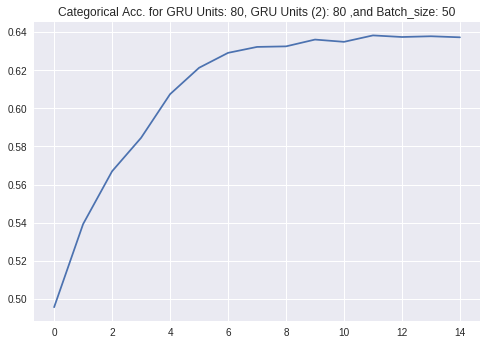

In [0]:
plt.plot(model_fit.history['categorical_accuracy'])
plt.title('Categorical Acc. for GRU Units: ' + str(GRU_UNITS) + ', GRU Units (2): ' + str(GRU_UNITS_2) + ' ,and Batch_size: ' + str(BATCH_SIZE))

plt.savefig(basepath + 'Graphs/RNN_accuracy_' + str(GRU_UNITS) + '_' + str(GRU_UNITS_2) + '_' + str(BATCH_SIZE) + '.png', dpi=200)
plt.show()

## Evaluate the Model

In [0]:
rnn_model.load_weights(chkpoint_path)

In [0]:
y_pred = rnn_model.predict(X_test, batch_size=BATCH_SIZE)

In [0]:
def convert_y(y):
  y_conv = [j for i in range(len(y)) for j in range(len(y[i][0])) if y[i][0][j]==np.amax(y[i][0])]
        
  return np.array(y_conv)

In [0]:
# print(y_pred)
print(y_pred[1888][0])
print(convert_y(y_pred))

[6.9292434e-02 7.5730574e-01 8.9423113e-02 1.5610896e-04 3.0643011e-02
 5.3179611e-02]
[0 0 0 ... 0 0 0]


In [0]:
y_t = convert_y(y_test)
y_p = convert_y(y_pred)
      
print("GRU units: ", GRU_UNITS)
print('GRU units 2: ', GRU_UNITS_2)
print("Batch size: ", BATCH_SIZE)
print()
  
score = confusion_matrix(y_t, y_p, labels=[0,1,2,4,5])
acc_score = accuracy_score(y_t, y_p)

print("Accuracy: ", acc_score)
print("Confusion matrix: \n" , score)

GRU units:  80
GRU units 2:  80
Batch size:  50

Accuracy:  0.4028254936586932
Confusion matrix: 
 [[2326 3784    0  247   42]
 [1552 8307    0   51   48]
 [1621 4237    0   58   34]
 [  78 5749    0 1717    0]
 [   2 1096    0    0  196]]


### Note (1)
* ** 0 - NaN **
* ** 1 - Stand **
* ** 2 - Walk **
* ** 4 - Sit **
* ** 5 - Lie **

### Note (2)

* **GRU units = 150, Batch_size = 100,  acc = 0.3738**

* **GRU units = 150, Batch_size = 80,  acc = 0.4235**

* **GRU units = 170, Batch_size = 80,  acc = 0.4255**

* **GRU units = 170, Batch_size = 60,  acc = 0.4146**

* **GRU units = 170, Batch_size = 90,  acc = 0.4230**

--------------

* **GRU units = 150, GRU units (2) = 150, Batch_size = 80,  acc = 0.4164**

* **GRU units = 180, GRU units (2) = 150, Batch_size = 80,  acc = 0.4257**

* **GRU units = 180, GRU units (2) = 180, Batch_size = 80,  acc = 0.4284**

* **GRU units = 200, GRU units (2) = 200, Batch_size = 80,  acc = 0.4158**

* **GRU units = 190, GRU units (2) = 190, Batch_size = 80,  acc = 0.4253**

* **GRU units = 180, GRU units (2) = 190, Batch_size = 80,  acc = 0.4384**

* **GRU units = 180, GRU units (2) = 210, Batch_size = 80,  acc = 0.4158**

* **GRU units = 180, GRU units (2) = 180, Batch_size = 70,  acc = 0.4356**

* **GRU units = 180, GRU units (2) = 180, Batch_size = 50,  acc = 0.4423**

* **GRU units = 180, GRU units (2) = 180, Batch_size = 10,  acc = 0.4361**

* **GRU units = 180, GRU units (2) = 180, Batch_size = 100,  acc = 0.4013**

* **GRU units = 90, GRU units (2) = 90, Batch_size = 50,  acc = 0.4428**     <---------  Maximum :-(  ---------

* **GRU units = 60, GRU units (2) = 60, Batch_size = 50,  acc = 0.4258**

* **GRU units = 60, GRU units (2) = 60, Batch_size = 50,  acc = 0.4028**

---------

> // Changed LR = 0.0015, LR drop = 0.9, and Epochs drop = 9.0

* **GRU units = 180, GRU units (2) = 180, Batch_size = 80,  acc = 0.4017**

## **Testing Area**